Step1 顔認識したい人の名前を複数定義する

In [1]:
# 顔認識する対象を決定（検索ワードを入力）
SearchName = ["菅井友香","宮田愛萌","東村芽依","小池美波","小坂菜緒"]
# 画像の取得枚数の上限
ImgNumber =600
# CNNで学習するときの画像のサイズを設定（サイズが大きいと学習に時間がかかる）
ImgSize=(250,250)
input_shape=(250,250,3)

In [2]:
import os
# オリジナル画像用のフォルダ
os.makedirs("./Original", exist_ok=True)
# 顔の画像用のフォルダ
os.makedirs("./Face", exist_ok=True)
# ImgSizeで設定したサイズに編集された顔画像用のフォルダ
os.makedirs("./FaceEdited", exist_ok=True)
# テストデータを入れる用のフォルダ
os.makedirs("./test", exist_ok=True)

In [3]:
import json
from urllib import parse
from bs4 import BeautifulSoup

import requests

class Google:
    def __init__(self):
        self.GOOGLE_SEARCH_URL = 'https://www.google.co.jp/search'
        self.session = requests.session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:57.0) Gecko/20100101 Firefox/57.0'
        })
    def Search(self, keyword, type='text', maximum=1000):
        '''Google検索'''
        print('Google', type.capitalize(), 'Search :', keyword)
        result, total = [], 0
        query = self.query_gen(keyword, type)
        while True:
            # 検索
            html = self.session.get(next(query)).text
            links = self.get_links(html, type)

            # 検索結果の追加
            if not len(links):
                print('-> No more links')
                break
            elif len(links) > maximum - total:
                result += links[:maximum - total]
                break
            else:
                result += links
                total += len(links)

        print('-> 結果', str(len(result)), 'のlinksを取得しました')
        return result

    def query_gen(self, keyword, type):
        '''検索クエリジェネレータ'''
        page = 0
        while True:
            if type == 'text':
                params = parse.urlencode({
                    'q': keyword,
                    'num': '100',
                    'filter': '0',
                    'start': str(page * 100)})
            elif type == 'image':
                params = parse.urlencode({
                    'q': keyword,
                    'tbm': 'isch',
                    'filter': '0',
                    'ijn': str(page)})

            yield self.GOOGLE_SEARCH_URL + '?' + params
            page += 1

    def get_links(self, html, type):
        '''リンク取得'''
        soup = BeautifulSoup(html, 'lxml')
        if type == 'text':
            elements = soup.select('.rc > .r > a')
            links = [e['href'] for e in elements]
        elif type == 'image':
            elements = soup.select('.rg_meta.notranslate')
            jsons = [json.loads(e.get_text()) for e in elements]
            links = [js['ou'] for js in jsons]
        return links

In [ ]:
#画像のURLをgoogle検索から取得する
# インスタンス作成
google = Google()
for name in SearchName:
    # 画像検索
    ImgURLs = google.Search(name, type='image', maximum=ImgNumber)
    # 保存先のディレクトリ作成
    os.makedirs("./Original/"+str(name), exist_ok=True)

    #Originalファイルに画像を保存する
    for i,target in enumerate(ImgURLs): # ImgURLsからtargetに入れる
        try:
            re = requests.get(target, allow_redirects=False)
            with open("./Original/"+str(name)+'/' + str(i)+'.jpg', 'wb') as f: # imgフォルダに格納
                f.write(re.content) # .contentにて画像データとして書き込む
        except requests.exceptions.ConnectionError:
            continue
        except UnicodeEncodeError:
            continue
        except UnicodeError:
            continue
        except IsADirectoryError:
            continue

print("保存完了しました") # 確認

Google Image Search : 菅井友香
-> No more links
-> 結果 517 のlinksを取得しました


Step3 顔部分を抽出し切り抜く

In [7]:
# -*- coding:utf-8 -*-
import cv2
import numpy as np

# OpenCVのデフォルトの分類器のpath。(https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xmlのファイルを使う)
cascade_path = './haarcascade_frontalface_default.xml'
# 例
#cascade_path = './opencv-master/data/haarcascades/haarcascade_frontalface_default.xml'

#faceCascade = cv2.CascadeClassifier(cascade_path)

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")


In [9]:
for name in SearchName:
    #directory of original image
    input_data_path = "./Original/"+str(name)
    #切り抜いた画像の保存先ディレクトリ作成
    os.makedirs("./Face/"+str(name)+"_face", exist_ok=True)
    save_path = "./Face/"+str(name)+"_face/"
    #収集した画像の枚数（任意で変更可能）
    image_count = ImgNumber
    #検知成功した枚数（デフォルトで0）
    face_detect_count = 0
    
    print("{}の顔を検出し、切り出しを開始します。".format(name))
    #集めた画像データから顔が検知されたら切り取って保存
    
    for i in range(image_count):
        img = cv2.imread(input_data_path + '/' + str(i) + '.jpg', cv2.IMREAD_COLOR)
        if img is None:
            print('image' + str(i) + ':NoFace')
        else:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            face = faceCascade.detectMultiScale(gray, 1.1, 3)
            
            if len(face) > 0:
                for rect in face:
                    # 顔認識部分を赤線で囲み保存(今はこの部分は必要ない)
                    # cv2.rectangle(img, tuple(rect[0:2]), tuple(rect[0:2]+rect[2:4]), (0, 0,255), thickness=1)
                    # cv2.imwrite('detected.jpg', img)
                    x = rect[0]
                    y = rect[1]
                    w = rect[2]
                    h = rect[3]
                    cv2.imwrite(save_path + 'cutted' + str(face_detect_count) + '.jpg',img[y:y+h,  x:x+w])
                    face_detect_count = face_detect_count + 1
                else:
                    print('image' + str(i) + ':NoFace')
print("正常に終了しました。")

菅井友香の顔を検出し、切り出しを開始します。
image0:NoFace
image1:NoFace
image2:NoFace
image3:NoFace
image4:NoFace
image5:NoFace
image6:NoFace
image7:NoFace
image8:NoFace
image9:NoFace
image10:NoFace
image11:NoFace
image12:NoFace
image13:NoFace
image14:NoFace
image15:NoFace
image17:NoFace
image18:NoFace
image19:NoFace
image21:NoFace
image22:NoFace
image23:NoFace
image24:NoFace
image25:NoFace
image26:NoFace
image28:NoFace
image29:NoFace
image30:NoFace
image31:NoFace
image32:NoFace
image33:NoFace
image34:NoFace
image35:NoFace
image36:NoFace
image37:NoFace
image38:NoFace
image39:NoFace
image40:NoFace
image41:NoFace
image42:NoFace
image43:NoFace
image44:NoFace
image45:NoFace
image46:NoFace
image47:NoFace
image48:NoFace
image49:NoFace
image50:NoFace
image52:NoFace
image53:NoFace
image54:NoFace
image55:NoFace
image56:NoFace
image57:NoFace
image58:NoFace
image59:NoFace
image60:NoFace
image61:NoFace
image63:NoFace
image64:NoFace
image65:NoFace
image66:NoFace
image67:NoFace
image68:NoFace
image69:NoFace
image70:NoFa

image2:NoFace
image3:NoFace
image4:NoFace
image5:NoFace
image6:NoFace
image8:NoFace
image9:NoFace
image10:NoFace
image11:NoFace
image13:NoFace
image15:NoFace
image16:NoFace
image17:NoFace
image18:NoFace
image19:NoFace
image20:NoFace
image21:NoFace
image22:NoFace
image23:NoFace
image24:NoFace
image25:NoFace
image26:NoFace
image27:NoFace
image28:NoFace
image30:NoFace
image31:NoFace
image32:NoFace
image33:NoFace
image35:NoFace
image36:NoFace
image38:NoFace
image40:NoFace
image42:NoFace
image43:NoFace
image45:NoFace
image47:NoFace
image48:NoFace
image49:NoFace
image50:NoFace
image52:NoFace
image53:NoFace
image56:NoFace
image57:NoFace
image58:NoFace
image61:NoFace
image63:NoFace
image64:NoFace
image65:NoFace
image67:NoFace
image68:NoFace
image69:NoFace
image70:NoFace
image71:NoFace
image72:NoFace
image73:NoFace
image74:NoFace
image75:NoFace
image76:NoFace
image77:NoFace
image78:NoFace
image79:NoFace
image80:NoFace
image81:NoFace
image82:NoFace
image83:NoFace
image84:NoFace
image85:NoFace
im

image18:NoFace
image19:NoFace
image20:NoFace
image21:NoFace
image22:NoFace
image23:NoFace
image24:NoFace
image25:NoFace
image26:NoFace
image27:NoFace
image28:NoFace
image29:NoFace
image30:NoFace
image31:NoFace
image33:NoFace
image34:NoFace
image35:NoFace
image36:NoFace
image37:NoFace
image38:NoFace
image39:NoFace
image40:NoFace
image41:NoFace
image43:NoFace
image44:NoFace
image45:NoFace
image46:NoFace
image47:NoFace
image48:NoFace
image49:NoFace
image50:NoFace
image51:NoFace
image52:NoFace
image53:NoFace
image55:NoFace
image56:NoFace
image57:NoFace
image58:NoFace
image59:NoFace
image60:NoFace
image61:NoFace
image62:NoFace
image63:NoFace
image64:NoFace
image65:NoFace
image66:NoFace
image67:NoFace
image68:NoFace
image69:NoFace
image70:NoFace
image71:NoFace
image72:NoFace
image73:NoFace
image75:NoFace
image76:NoFace
image77:NoFace
image78:NoFace
image79:NoFace
image81:NoFace
image82:NoFace
image83:NoFace
image86:NoFace
image87:NoFace
image89:NoFace
image90:NoFace
image91:NoFace
image92:No

image22:NoFace
image23:NoFace
image24:NoFace
image25:NoFace
image26:NoFace
image27:NoFace
image28:NoFace
image29:NoFace
image30:NoFace
image31:NoFace
image32:NoFace
image33:NoFace
image34:NoFace
image35:NoFace
image36:NoFace
image38:NoFace
image39:NoFace
image40:NoFace
image41:NoFace
image42:NoFace
image43:NoFace
image44:NoFace
image45:NoFace
image46:NoFace
image47:NoFace
image48:NoFace
image49:NoFace
image50:NoFace
image51:NoFace
image52:NoFace
image53:NoFace
image54:NoFace
image55:NoFace
image56:NoFace
image58:NoFace
image59:NoFace
image60:NoFace
image61:NoFace
image62:NoFace
image63:NoFace
image64:NoFace
image65:NoFace
image66:NoFace
image67:NoFace
image68:NoFace
image69:NoFace
image70:NoFace
image71:NoFace
image72:NoFace
image73:NoFace
image74:NoFace
image75:NoFace
image76:NoFace
image77:NoFace
image78:NoFace
image79:NoFace
image80:NoFace
image81:NoFace
image82:NoFace
image83:NoFace
image84:NoFace
image85:NoFace
image86:NoFace
image87:NoFace
image88:NoFace
image90:NoFace
image91:No

image27:NoFace
image29:NoFace
image31:NoFace
image32:NoFace
image33:NoFace
image34:NoFace
image37:NoFace
image38:NoFace
image39:NoFace
image40:NoFace
image41:NoFace
image43:NoFace
image44:NoFace
image46:NoFace
image48:NoFace
image49:NoFace
image50:NoFace
image51:NoFace
image53:NoFace
image54:NoFace
image55:NoFace
image56:NoFace
image57:NoFace
image58:NoFace
image59:NoFace
image60:NoFace
image61:NoFace
image62:NoFace
image64:NoFace
image66:NoFace
image67:NoFace
image68:NoFace
image69:NoFace
image70:NoFace
image71:NoFace
image73:NoFace
image74:NoFace
image76:NoFace
image77:NoFace
image78:NoFace
image79:NoFace
image81:NoFace
image83:NoFace
image84:NoFace
image85:NoFace
image88:NoFace
image89:NoFace
image90:NoFace
image91:NoFace
image92:NoFace
image93:NoFace
image94:NoFace
image95:NoFace
image96:NoFace
image97:NoFace
image98:NoFace
image99:NoFace
image101:NoFace
image102:NoFace
image103:NoFace
image104:NoFace
image105:NoFace
image106:NoFace
image107:NoFace
image108:NoFace
image109:NoFace
i

In [ ]:
import os
import cv2
import glob
from scipy import ndimage
"""
Faceディレクトリから画像を読み込んで回転、ぼかし、閾値処理をしてFaceEditedディレクトリに保存する.
"""
for name in SearchName:
    print("{}の写真を増やします。".format(name))
    in_dir = "./Face/"+name+"_face/*"
    out_dir = "./FaceEdited/"+name
    os.makedirs(out_dir, exist_ok=True)
    in_jpg=glob.glob(in_dir)
    img_file_name_list=os.listdir("./Face/"+name+"_face/")
    for i in range(len(in_jpg)):
        #print(str(in_jpg[i]))
        img = cv2.imread(str(in_jpg[i]))
        # 回転
        for ang in [-10,0,10]:
            img_rot = ndimage.rotate(img,ang)
            img_rot = cv2.resize(img_rot,ImgSize)
            fileName=os.path.join(out_dir,str(i)+"_"+str(ang)+".jpg")
            cv2.imwrite(str(fileName),img_rot)
            # 閾値
            img_thr = cv2.threshold(img_rot, 100, 255, cv2.THRESH_TOZERO)[1]
            fileName=os.path.join(out_dir,str(i)+"_"+str(ang)+"thr.jpg")
            cv2.imwrite(str(fileName),img_thr)
            # ぼかし
            img_filter = cv2.GaussianBlur(img_rot, (5, 5), 0)
            fileName=os.path.join(out_dir,str(i)+"_"+str(ang)+"filter.jpg")
            cv2.imwrite(str(fileName),img_filter)

print("画像の水増しに大成功しました！")

Step6 トレーニングデータ、テストデータの準備

In [5]:
# 2割をテストデータに移行
import shutil
import random
import glob
import os

for name in SearchName:
    in_dir = "./FaceEdited/"+name+"/*"
    in_jpg=glob.glob(in_dir)
    img_file_name_list=os.listdir("./FaceEdited/"+name+"/")
    #img_file_name_listをシャッフル、そのうち2割をtest_imageディテクトリに入れる
    random.shuffle(in_jpg)
    os.makedirs('./test/' + name, exist_ok=True)
    for t in range(len(in_jpg)//5):
        shutil.move(str(in_jpg[t]), "./test/"+name)

Error: Destination path './test/菅井友香/298_0thr.jpg' already exists

In [3]:
from keras.utils.np_utils import to_categorical
import cv2
import numpy as np

# 教師データのラベル付け
X_train = [] 
Y_train = [] 
for i in range(len(SearchName)):
    img_file_name_list=os.listdir("./FaceEdited/"+SearchName[i])
    print("{}:トレーニング用の写真の数は{}枚です。".format(SearchName[i],len(img_file_name_list)))

    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./FaceEdited/"+SearchName[i]+"/",img_file_name_list[j])  
        img = cv2.imread(n)
        if img is None:
            print('image' + str(j) + ':NoImage')
            continue    
        else:
            r,g,b = cv2.split(img)
            img = cv2.merge([r,g,b])
            X_train.append(img)
            Y_train.append(i)

print("")

# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(SearchName)):
    img_file_name_list=os.listdir("./test/"+SearchName[i])
    print("{}:テスト用の写真の数は{}枚です。".format(SearchName[i],len(img_file_name_list)))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+SearchName[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        if img is None:
            print('image' + str(j) + ':NoImage')
            continue    
        else:
            r,g,b = cv2.split(img)
            img = cv2.merge([r,g,b])
            X_test.append(img)
            Y_test.append(i)

X_train=np.array(X_train)
X_test=np.array(X_test)
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

Using TensorFlow backend.
/Users/yuichikato/.pyenv/versions/anaconda3-5.2.0/envs/py363/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


菅井友香:トレーニング用の写真の数は2690枚です。
宮田愛萌:トレーニング用の写真の数は1980枚です。
東村芽依:トレーニング用の写真の数は2790枚です。
小池美波:トレーニング用の写真の数は2367枚です。
小坂菜緒:トレーニング用の写真の数は744枚です。

菅井友香:テスト用の写真の数は1088枚です。
宮田愛萌:テスト用の写真の数は800枚です。
image125:NoImage
東村芽依:テスト用の写真の数は1128枚です。
小池美波:テスト用の写真の数は957枚です。
小坂菜緒:テスト用の写真の数は1063枚です。


In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10566, 250, 250, 3), (10566, 5), (5030, 250, 250, 3), (5030, 5))

Step7 Kerasによるモデルの構築, 学習, 評価

In [5]:
from keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Sequential

# モデルの定義
model = Sequential()
model.add(Conv2D(input_shape=input_shape, filters=32,kernel_size=(3, 3), 
                 strides=(1, 1), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                 strides=(1, 1), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                 strides=(1, 1), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("sigmoid"))
model.add(Dense(128))
model.add(Activation('sigmoid'))
# 分類したい人数を入れる
model.add(Dense(len(SearchName)))
model.add(Activation('softmax'))

# コンパイル
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
# 学習
history = model.fit(X_train, y_train, batch_size=70, epochs=5)

Epoch 1/5
10566/10566 [==============================] - 1579s 149ms/step - loss: 1.5353 - acc: 0.2849
Epoch 2/5
10566/10566 [==============================] - 1305s 123ms/step - loss: 1.5238 - acc: 0.3066
Epoch 3/5
10566/10566 [==============================] - 1353s 128ms/step - loss: 1.5058 - acc: 0.3651
Epoch 4/5
10566/10566 [==============================] - 1155s 109ms/step - loss: 1.4749 - acc: 0.4202
Epoch 5/5
10566/10566 [==============================] - 1202s 114ms/step - loss: 1.4264 - acc: 0.4534


AAAAAAAAAAAA
5030/5030 [==============================] - 205s 41ms/step
validation loss:1.1333585038573795
validation accuracy:0.5771371769383697
AAAAAAAAAAAA


KeyError: 'val_acc'

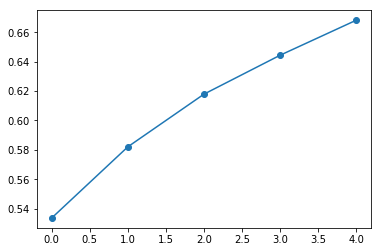

In [13]:
import matplotlib.pyplot as plt

# 汎化制度の評価・表示
print('AAAAAAAAAAAA')

score = model.evaluate(X_test, y_test, batch_size=32)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

print('AAAAAAAAAAAA')

#acc, val_accのプロット
plt.plot(history.history["acc"], label="acc", ls="-", marker="o")
plt.plot(history.history["val_acc"], label="val_acc", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

print('AAAAAAAAAAAA')


#モデルを保存
model.save("MyModel.h5")

#なんか実行待ちになってタイムアウトしちゃうのかな？何だろう

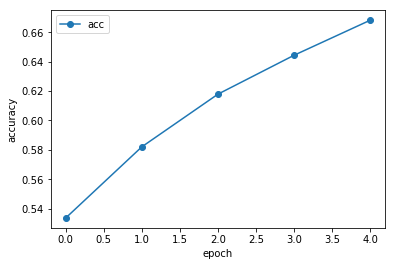

AAAAAAAAAAAA


In [14]:
#acc, val_accのプロット
plt.plot(history.history["acc"], label="acc", ls="-", marker="o")
#plt.plot(history.history["val_acc"], label="val_acc", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

print('AAAAAAAAAAAA')


#モデルを保存
model.save("MyModel.h5")